## <center>Lux ABM<center>

This is a (slightly modified) implementation of the ABM model proposed by Alfarano and Lux (2007).

The basic dynamics of the model are described by the following ODE:

$$
\frac{dp}{dt} = \beta \ [ N_F T_F (p_f - p) + N_C T_C x ] \ p, \qquad x = \frac{N_o - N_p}{N_C}
$$

where $p$ is the market price of the stock, $p_f$ is the intrinsic value of the stock, $N_F$ is the number of fundamentalist traders, and $N_C$ is the number of noise traders. $N_F$ and $N_C$ are chosen beforehand and are fixed throughout the simulation.

$N_o$ is the number of noise traders who are optimists and $N_p$ is the number of noise traders who are pessimists (where $N_o + N_p = N_c$). $N_o$ and $N_p$ are dynamic and change throughout the simulation (described below). We also add a boundary condition in the implementation to ensure that there is at least one of each type of trader at all times (i.e. $N_o \gt 0$ and $N_p \gt 0$).

$\beta$, $T_F$, and $T_C$ are essentially parameters to tune the model.

Some intuition about the ODE can be seen by rewriting it as follows:

$$
\frac{dp}{dt} = p \ [\beta N_F T_F] (p_f - p) + p \ [\beta N_C T_C] \ x
$$

Note that all values in the brackets are constants. The first expression on the right is just an exponential with a mean reverting term added to it. In words, the model pulls the price back to its fundamental value when it diverges too far. The second expression on the right is also essentially an exponential form, but has noise $x$ added to it. Note that, given the definition of $x$, this noise is always in the interval $x \in (-1, 1)$ and has (stochastic) attractors at -1 and 1, so it can pull the value of the stock above or below the intrinsic value for long periods of time during the simulation.

The value of $p_f$ is constant in the paper, but the intrinsic value drives the valuation of a stock over time, so I've made this an exponential function in the implementation below:
$$
\frac{dp_f}{dt} = \mu p_f
$$

This allows the market to grow over time like a real stock market.

The simulation initially starts by randomly designating each noise trader an optimist or pessimist. For each timestep, each optimist has a probability $p_o$ of switching to a pessimist and each pessimist has a probability $p_p$ of switching to an optimist, where the switches are Bernoulli and are assigned the following probabilities:
$$
p_o = \nu \Delta t \frac{N_p}{N}
$$

$$
p_p = \nu \Delta t \frac{N_o}{N}
$$

where $\Delta t$ is the simulation timestep. We see from these definitions that when the majority of noise traders are pessimists (optimists), the few remaining optimists (pessimists) will have a high probability of switching to pessimists (optimists), while the pessimists (optimists) will have a low probability of switching to optimists (pessimists). In other words, the system is attracted to the states where the majority of traders are either pessimists or optimists and there is a low probability to switching out of these states.

The simulation is implemented using forward Euler discretization.

Set use_pycx to True for an interactive simulation (you'll need to expend the size of the dialog that pops up to see all the plots). Each tiny square in the bar on the top represents a trader (orange for optimist and gray for pessimist). The second bar just aggregates the results to get a quick view of whether the market overall is optimistic or pessimistic. The first time series plots optimists and pessimists. The second plots the fundamental (intrinsic) value and the simulated market price. The third plots the returns.

In [1]:
use_pycx = False

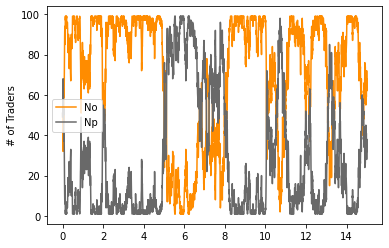

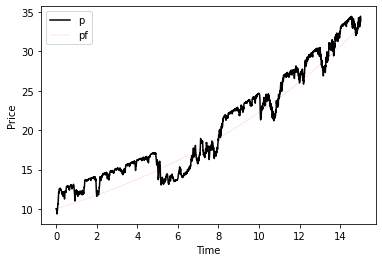

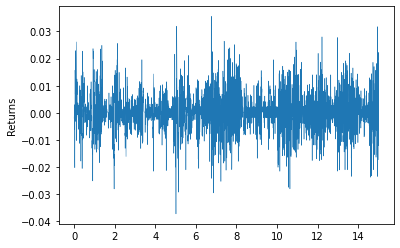

In [2]:
from pylab import *
from matplotlib import gridspec

seed(1234)

T = 15.
Dt = 1./252  # 252 trading days in a year

Nf = 100
Nc = 100

b = 0.1
Tf = 1     # size of trades made by fundamentalist traders
Tc = 2.5   # size of trades made by noise traders

nu = 0.9/Dt

mu = 0.08   # annual growth of pf


def initialize():
    global p, pf, No, Np, x, t, pvec, pfvec, Novec, Npvec, xvec, traders, tvec    
    
    pf = 10.0
    p = pf
   
    traders = zeros([1, Nc])
    for i in range(Nc):
        traders[0, i] = randint(0, 2)

    No = len(traders[0, traders[0,:] > 0])   # optimist = 1
    Np = len(traders[0, traders[0,:] == 0])  # pessimist = 0
    
    x = (No - Np) / Nc
    t = 0.
    
    pvec = [p]
    pfvec = [pf]
    Novec = [No]
    Npvec = [Np]
    xvec = [x]
    tvec = [t]

    
def observe():
    global p, pf, No, Np, x, t, pvec, pfvec, Novec, Npvec, xvec, traders, tvec    
    pvec.append(p)
    pfvec.append(pf)
    Novec.append(No)
    Npvec.append(Np)
    xvec.append(x)
    tvec.append(t)


def update():
    global p, pf, No, Np, x, t, pvec, pfvec, Novec, Npvec, xvec, traders, tvec

    np = p + p * b * (Nf * Tf * (pf - p) + Nc * Tc * x) * Dt

    p_o = nu*Dt*Np/Nc      # probability that optimist switches to pessimist
    p_p = nu*Dt*No/Nc      # probability that pessimist switches to optimist
    
    optim = binomial(1, 1 - p_o, Nc)     # 1 - p_o is probability of staying an optimist
    pessim = binomial(1, p_p, Nc)        # p_p is probability of switching optimist
    for i in range(Nc):
        if traders[0, i] > 0:            # optimist
            traders[0, i] = optim[i]
        else:                            # pessimist
            traders[0, i] = pessim[i]
    
    nNo = len(traders[0, traders[0,:] > 0])
    nNp = len(traders[0, traders[0,:] == 0])
    if nNp < 1:      # Np = 0 is an absorbing state, so implement refecting boundary
        nNp = 1
        nNo = Nc - 1
    if nNo < 1:      # No = 0 is an absorbing state, so implement refecting boundary
        nNo = 1
        nNp = Nc - 1
        
    nx = (No - Np) / Nc

    npf = pf + mu*pf*Dt
    
    t = t + Dt
    
    p, pf, No, Np, x = np, npf, nNo, nNp, nx
    
    observe()


cmap = mpl.colors.ListedColormap(['dimgray', 'darkorange'])
bounds = [0., 0.5, 1.]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

def observe_pycx():
    cla()
    gs = gridspec.GridSpec(5, 1, height_ratios=[1, 1, 10, 10, 10]) 

    ax1 = subplot(gs[0])
    ax1.title.set_text("Indivdual Traders")
    imshow(traders, cmap = cmap, norm=norm)
    plt.axis('off')
    axis([0, N, 0, 1])

    ax2 = subplot(gs[1])
    ax2.title.set_text("Total Pessimists/Optimists")
    imshow(sort(traders), cmap = cmap, norm=norm)
    plt.xlabel('Traders')
    plt.axis('off')
    axis([0, N, 0, 1])

    subplot(gs[2])
    plot(traders)
    plot(tvec, Novec, 'darkorange', label='No')
    plot(tvec, Npvec, 'dimgray', label='Np')
    ylabel('# of Traders')
    legend()

    subplot(gs[3])
    plot(tvec, pvec, label='p')
    plot(tvec, pfvec, 'r', label='pf')
    xlabel('Time')
    ylabel('Price')
    legend()

    subplot(gs[4])
    plot(tvec[1:], diff(log(pvec)), 'k', linewidth=0.5)
    ylabel('Returns')

    
if use_pycx:
    
    import pycxsimulator
    pycxsimulator.GUI(stepSize = 10).start(func=[initialize, observe_pycx, update])

else:

    initialize()
    while t < T:
        update()

    plot(tvec, Novec, 'darkorange', label='No')
    plot(tvec, Npvec, 'dimgray', label='Np')
    ylabel('# of Traders')
    legend()
    show()
    
    plot(tvec, pvec, 'k',label='p')
    plot(tvec, pfvec, 'r', label='pf', linewidth=0.1)
    xlabel('Time')
    ylabel('Price')
    legend()
    show()

    plot(tvec[1:], diff(log(pvec)), linewidth=0.5)
    ylabel('Returns')
    show()


In [3]:
import numpy as np
import scipy.stats as stats

r = diff(log(pvec))
    
mu = np.mean(r)
sigma = np.std(r)
sigma2 = np.var(r)
skew = stats.skew(r)
kurt = stats.kurtosis(r)

print('Daily return statistics:')
print('Mean:\t\t\t', mu)
print('Std dev:\t\t', sigma)
print('Variance:\t\t', sigma2)
print('Skew:\t\t\t', skew)
print('Excess kurt:\t\t', kurt)
print()

mu_a = mu * 252                       # this is in same unit as mu parameter for GBM
sigma_a = sigma * np.sqrt(252)        # this is in same unit as sigma parameter for GBM
sigma2_a = sigma2 * 252

print('Annualized return statistics:')
print('Mean (mu):\t\t', mu_a)
print('Std dev (sigma):\t', sigma_a)
print('Variance:\t\t', sigma2_a)

Daily return statistics:
Mean:			 0.0003227822630720671
Std dev:		 0.007039985584166273
Variance:		 4.956139702526894e-05
Skew:			 0.021283895996766323
Excess kurt:		 2.137152536537857

Annualized return statistics:
Mean (mu):		 0.0813411302941609
Std dev (sigma):	 0.1117563065351024
Variance:		 0.012489472050367772
